# Approximate q-learning

In this notebook you will teach a __tensorflow__ neural network to do Q-learning.

__Frameworks__ - we'll accept this homework in any deep learning framework. This particular notebook was designed for tensorflow, but you will find it easy to adapt it to almost any python-based deep learning framework.

In [1]:
#XVFB will be launched if you run on a server
import os
if os.environ.get("DISPLAY") is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

Starting virtual X frame buffer: Xvfbstart-stop-daemon: unable to open pidfile './xvfb.pid' for writing (Permission denied)
start-stop-daemon: child returned error exit status 2 (Permission denied)
.
env: DISPLAY=:1


In [2]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

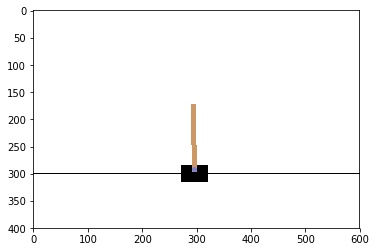

In [3]:
env = gym.make("CartPole-v0").env
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render("rgb_array"))

# Approximate (deep) Q-learning: building the network

To train a neural network policy one must have a neural network policy. Let's build it.


Since we're working with a pre-extracted features (cart positions, angles and velocities), we don't need a complicated network yet. In fact, let's build something like this for starters:

![img](https://github.com/yandexdataschool/Practical_RL/blob/master/yet_another_week/_resource/qlearning_scheme.png?raw=true)

For your first run, please only use linear layers (L.Dense) and activations. Stuff like batch normalization or dropout may ruin everything if used haphazardly. 

Also please avoid using nonlinearities like sigmoid & tanh: agent's observations are not normalized so sigmoids may become saturated from init.

Ideally you should start small with maybe 1-2 hidden layers with < 200 neurons and then increase network size if agent doesn't beat the target score.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
class NN(nn.Module):
    def __init__(self, state_dim, n_actions):
        super(NN, self).__init__()
        # input state_dim, output n_actions
        self.l1 = nn.Linear(state_dim, 128)
        self.l2 = nn.Linear(128, 64)
        self.l3 = nn.Linear(64, n_actions)
    
    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return x

In [6]:
network = NN(state_dim, n_actions).to(device)
print(network)

NN(
  (l1): Linear(in_features=4, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=64, bias=True)
  (l3): Linear(in_features=64, out_features=2, bias=True)
)


In [7]:
def get_action(state, epsilon=0):
    """
    sample actions with epsilon-greedy policy
    recap: with p = epsilon pick random action, else pick action with highest Q(s,a)
    """
    state = torch.tensor(state).unsqueeze(0).float()
    q_values = policy_net(state).squeeze(0)  # type: tensor
    threshold = np.random.random()
    
    action = q_values.argmax().item()
    if threshold < epsilon:  # random action
        action = np.random.choice(n_actions)

    return action

### Q-learning via gradient descent

We shall now train our agent's Q-function by minimizing the TD loss:
$$ L = { 1 \over N} \sum_i (Q_{\theta}(s,a) - [r(s,a) + \gamma \cdot max_{a'} Q_{-}(s', a')]) ^2 $$


Where
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.

The tricky part is with  $Q_{-}(s',a')$. From an engineering standpoint, it's the same as $Q_{\theta}$ - the output of your neural network policy. However, when doing gradient descent, __we won't propagate gradients through it__ to make training more stable (see lectures).

To do so, we shall use `tf.stop_gradient` function which basically says "consider this thing constant when doingbackprop".

# Debug the code

get_action -> int (1)

state -> array(4, )

done -> bool (1)

reward -> float (1)

In [318]:
state, reward, done, _ = env.step(0)
done
q_values = network(torch.tensor(state).float())

In [319]:
next_state = state

In [262]:
print(state)
print(done)
print(r)
print(action)
print(q_values)

[-0.01897919 -1.13381844  0.0577046   1.77772946]
False
1.0
0
tensor([0.0144, 0.1118], grad_fn=<ThAddBackward>)


In [249]:
#select q-values for chosen actions
actions = torch.tensor(1).unsqueeze(0)
actions.shape

torch.Size([1])

In [260]:
q_values.gather(0, torch.tensor(action))

tensor([0.0144], grad_fn=<GatherBackward>)

In [264]:
q_values.max()

tensor(0.1118, grad_fn=<MaxBackward1>)

In [2]:
torch.where(torch.tensor(done), torch.tensor(reward), torch.tensor(1.23))

NameError: name 'torch' is not defined

In [320]:
state = torch.tensor(state).float()
next_state = torch.tensor(next_state).float()
predicted_qvalues = policy_net(state)
predicted_qvalues_for_actions = predicted_qvalues.gather(0, torch.tensor(action))

predicted_next_qvalues = target_net(next_state)
next_state_values = predicted_next_qvalues.max()

target_qvalues_for_actions = reward + 0.99*next_state_values
target_qvalues_for_actions = torch.where(torch.tensor(done), \
                             torch.tensor(reward), \
                             torch.tensor(target_qvalues_for_actions))

loss = (predicted_qvalues_for_actions - target_qvalues_for_actions)**2
# print('debug')
# print(state)
# print(next_state)
# print(action, reward, done)
# print(predicted_qvalues, predicted_qvalues_for_actions)
# print(predicted_next_qvalues, next_state_values)
# print(target_qvalues_for_actions)

optimizer.zero_grad()
loss.backward()
optimizer.step()


In [333]:
loss.grad_fn.next_functions[0][0].next_functions[0][0].next_functions[0][0].next_functions[0][0].next_functions[0][0]

# Main

In [10]:
#get q-values for all actions in current states
predicted_qvalues = network(states_ph)

#select q-values for chosen actions
predicted_qvalues_for_actions = tf.reduce_sum(predicted_qvalues * tf.one_hot(actions_ph, n_actions), axis=1)

NameError: name 'states_ph' is not defined

### Playing the game

In [14]:
def get_action(state, epsilon=0):
    """
    sample actions with epsilon-greedy policy
    recap: with p = epsilon pick random action, else pick action with highest Q(s,a)
    """
    state = torch.tensor(state).unsqueeze(0).float()
    q_values = policy_net(state).squeeze(0)  # type: tensor
    threshold = np.random.random()
    
    action = q_values.argmax().item()
    if threshold < epsilon:  # random action
        action = np.random.choice(n_actions)

    return action

In [1]:
policy_net = NN(n_actions=n_actions, state_dim=state_dim).to(device)
target_net = NN(n_actions=n_actions, state_dim=state_dim).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(policy_net.parameters(), lr=1e-4)

def get_action(state, epsilon=0):
    """
    sample actions with epsilon-greedy policy
    recap: with p = epsilon pick random action, else pick action with highest Q(s,a)
    """
    state = torch.tensor(state).unsqueeze(0).float()
    q_values = policy_net(state).squeeze(0)  # type: tensor
    threshold = np.random.random()
    
    action = q_values.argmax().item()
    if threshold < epsilon:  # random action
        action = np.random.choice(n_actions)

    return action

def optimize_model(state, action, next_state, reward, done):
    state = torch.tensor(state).float()
    next_state = torch.tensor(next_state).float()
    predicted_qvalues = policy_net(state)
    predicted_qvalues_for_actions = predicted_qvalues.gather(0, torch.tensor(action))
    
    predicted_next_qvalues = target_net(next_state)
    next_state_values = predicted_next_qvalues.max()
    
    target_qvalues_for_actions = reward + 0.99*next_state_values
    target_qvalues_for_actions = torch.where(torch.tensor(done), \
                                 torch.tensor(reward), \
                                 torch.tensor(target_qvalues_for_actions))
    
    loss = (predicted_qvalues_for_actions - target_qvalues_for_actions)**2
    # print('debug')
    # print(state)
    # print(next_state)
    # print(action, reward, done)
    # print(predicted_qvalues, predicted_qvalues_for_actions)
    # print(predicted_next_qvalues, next_state_values)
    # print(target_qvalues_for_actions)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
def generate_session(t_max=1000, epsilon=0, train=False):
    """play env with approximate q-learning agent and train it at the same time"""
    total_reward = 0
    s = env.reset()
    
    for t in range(t_max):
        a = get_action(s, epsilon=epsilon)       
        next_s, r, done, _ = env.step(a)
        
        if train:
            optimize_model(s, a, next_s, r, done)
        if t%10 == 0:
            target_net.load_state_dict(policy_net.state_dict())
        total_reward += r
        s = next_s
        if done: break
            
    return total_reward

NameError: name 'NN' is not defined

In [16]:
epsilon = 0.5

In [17]:
session_rewards_list = []
for i in range(1000):
    session_rewards = [generate_session(epsilon=epsilon, train=True) for _ in range(100)]
    session_rewards_list.append(session_rewards)
    print("epoch #{}\tmean reward = {:.3f}\tepsilon = {:.3f}".format(i, np.mean(session_rewards), epsilon))
    
    epsilon *= 0.99
    assert epsilon >= 1e-4, "Make sure epsilon is always nonzero during training"
    
    if np.mean(session_rewards) > 300:
        print ("You Win!")
        break


epoch #0	mean reward = 14.450	epsilon = 0.500
epoch #1	mean reward = 13.770	epsilon = 0.495
epoch #2	mean reward = 14.870	epsilon = 0.490
epoch #3	mean reward = 13.690	epsilon = 0.485
epoch #4	mean reward = 14.990	epsilon = 0.480
epoch #5	mean reward = 13.450	epsilon = 0.475
epoch #6	mean reward = 18.940	epsilon = 0.471
epoch #7	mean reward = 23.510	epsilon = 0.466
epoch #8	mean reward = 39.840	epsilon = 0.461
epoch #9	mean reward = 44.910	epsilon = 0.457
epoch #10	mean reward = 50.120	epsilon = 0.452
epoch #11	mean reward = 56.980	epsilon = 0.448
epoch #12	mean reward = 66.440	epsilon = 0.443
epoch #13	mean reward = 89.030	epsilon = 0.439
epoch #14	mean reward = 127.860	epsilon = 0.434
epoch #15	mean reward = 147.710	epsilon = 0.430
epoch #16	mean reward = 165.120	epsilon = 0.426
epoch #17	mean reward = 154.510	epsilon = 0.421
epoch #18	mean reward = 184.250	epsilon = 0.417
epoch #19	mean reward = 168.960	epsilon = 0.413
epoch #20	mean reward = 172.840	epsilon = 0.409
epoch #21	mean r

### How to interpret results


Welcome to the f.. world of deep f...n reinforcement learning. Don't expect agent's reward to smoothly go up. Hope for it to go increase eventually. If it deems you worthy.

Seriously though,
* __ mean reward__ is the average reward per game. For a correct implementation it may stay low for some 10 epochs, then start growing while oscilating insanely and converges by ~50-100 steps depending on the network architecture. 
* If it never reaches target score by the end of for loop, try increasing the number of hidden neurons or look at the epsilon.
* __ epsilon__ - agent's willingness to explore. If you see that agent's already at < 0.01 epsilon before it's is at least 200, just reset it back to 0.1 - 0.5.

### Record videos

As usual, we now use `gym.wrappers.Monitor` to record a video of our agent playing the game. Unlike our previous attempts with state binarization, this time we expect our agent to act ~~(or fail)~~ more smoothly since there's no more binarization error at play.

As you already did with tabular q-learning, we set epsilon=0 for final evaluation to prevent agent from exploring himself to death.

In [344]:
#record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),directory="videos",force=True)
sessions = [generate_session(epsilon=0, train=False) for _ in range(100)]
env.close()


In [343]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

In [345]:
video_names

['openaigym.video.0.9523.video000064.mp4',
 'openaigym.video.0.9523.video000001.mp4',
 'openaigym.video.0.9523.video000027.mp4',
 'openaigym.video.0.9523.video000008.mp4',
 'openaigym.video.0.9523.video000000.mp4']

### Submit to coursera

In [29]:
import sys
import numpy as np
sys.path.append("..")
import grading

def submit_cartpole(generate_session, email, token):
    sessions = [generate_session() for _ in range(100)]
    #session_rewards, _, _ = map(np.array, zip(*sessions))
    session_rewards = np.array(sessions)
    grader = grading.Grader("RDofv-QXEeeaGw6kpIOf3g")
    grader.set_answer("NRNkl", int(np.mean(session_rewards)))
    grader.submit(email, token)

In [30]:
submit_cartpole(generate_session, "syuntoku14@gmail.com", "Q0Vrcl1sG66MiLkW")

Submitted to Coursera platform. See results on assignment page!
